In [1]:
import pandas as pd
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gammainc
import scipy.interpolate as inter
from scipy.interpolate import RectBivariateSpline

In [2]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

In [3]:
## Def out cosmology
cosmo = FlatLambdaCDM(H0=100 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

In [4]:
## Reading FITS
def read_fits(path):
    t = Table.read(path)
    df = pd.DataFrame()
    df = Table.to_pandas(t)
    del t
    return df

In [5]:
def calc_kcor(filter_name, redshift, colour_name, colour_value):
    """
    K-corrections calculator in Python. See http://kcor.sai.msu.ru for the 
    reference. Available filter-colour combinations must be present in the 
    `coeff` dictionary keys.

    @type   filter_name: string    
    @param  filter_name: Name of the filter to calculate K-correction for, e.g. 
                         'u', 'g', 'r' for some of the SDSS filters, or 'J2', 
                         'H2', 'Ks2' for 2MASS filters (must be present in 
                         `coeff` dictionary)
    @type      redshift: float    
    @param     redshift: Redshift of a galaxy, should be between 0.0 and 0.5 (no
                         check is made, however)
    @type   colour_name: string    
    @param  colour_name: Human name of the colour, e.g. 'u - g', 'g - r', 
                         'V - Rc', 'J2 - Ks2' (must be present in `coeff` dictionary)
    @type  colour_value: float    
    @param colour_value: Value of the galaxy's colour, specified in colour_name    
    @rtype:              float
    @return:             K-correction in specified filter for given redshift and 
                         colour
    @version:            2012
    @author:             Chilingarian, I., Melchior. A.-L., and Zolotukhin, I.
    @license:            Simplified BSD license, see http://kcor.sai.msu.ru/license.txt

    Usage example:
    
        >>> calc_kcor('g', 0.2, 'g - r', 1.1)
        0.5209713975999992
        >>> calc_kcor('Ic', 0.4, 'V - Ic', 2.0)
        0.310069919999993
        >>> calc_kcor('H', 0.5, 'H - K', 0.1)
        -0.14983142499999502
        
    """
    coeff = {

        'B_BRc': [
            [0,0,0,0],
            [-1.99412,3.45377,0.818214,-0.630543],
            [15.9592,-3.99873,6.44175,0.828667],
            [-101.876,-44.4243,-12.6224,0],
            [299.29,86.789,0,0],
            [-304.526,0,0,0],
        ],
        
        'B_BIc': [
            [0,0,0,0],
            [2.11655,-5.28948,4.5095,-0.8891],
            [24.0499,-4.76477,-1.55617,1.85361],
            [-121.96,7.73146,-17.1605,0],
            [236.222,76.5863,0,0],
            [-281.824,0,0,0],
        ],

        'H2_H2Ks2': [
            [0,0,0,0],
            [-1.88351,1.19742,10.0062,-18.0133],
            [11.1068,20.6816,-16.6483,139.907],
            [-79.1256,-406.065,-48.6619,-430.432],
            [551.385,1453.82,354.176,473.859],
            [-1728.49,-1785.33,-705.044,0],
            [2027.48,950.465,0,0],
            [-741.198,0,0,0],
        ],

        'H2_J2H2': [
            [0,0,0,0],
            [-4.99539,5.79815,4.19097,-7.36237],
            [70.4664,-202.698,244.798,-65.7179],
            [-142.831,553.379,-1247.8,574.124],
            [-414.164,1206.23,467.602,-799.626],
            [763.857,-2270.69,1845.38,0],
            [-563.812,-1227.82,0,0],
            [1392.67,0,0,0],
        ],

        'Ic_VIc': [
            [0,0,0,0],
            [-7.92467,17.6389,-15.2414,5.12562],
            [15.7555,-1.99263,10.663,-10.8329],
            [-88.0145,-42.9575,46.7401,0],
            [266.377,-67.5785,0,0],
            [-164.217,0,0,0],
        ],

        'J2_J2Ks2': [
            [0,0,0,0],
            [-2.85079,1.7402,0.754404,-0.41967],
            [24.1679,-34.9114,11.6095,0.691538],
            [-32.3501,59.9733,-29.6886,0],
            [-30.2249,43.3261,0,0],
            [-36.8587,0,0,0],
        ],

        'J2_J2H2': [
            [0,0,0,0],
            [-0.905709,-4.17058,11.5452,-7.7345],
            [5.38206,-6.73039,-5.94359,20.5753],
            [-5.99575,32.9624,-72.08,0],
            [-19.9099,92.1681,0,0],
            [-45.7148,0,0,0],
        ],

        'Ks2_J2Ks2': [
            [0,0,0,0],
            [-5.08065,-0.15919,4.15442,-0.794224],
            [62.8862,-61.9293,-2.11406,1.56637],
            [-191.117,212.626,-15.1137,0],
            [116.797,-151.833,0,0],
            [41.4071,0,0,0],
        ],

        'Ks2_H2Ks2': [
            [0,0,0,0],
            [-3.90879,5.05938,10.5434,-10.9614],
            [23.6036,-97.0952,14.0686,28.994],
            [-44.4514,266.242,-108.639,0],
            [-15.8337,-117.61,0,0],
            [28.3737,0,0,0],
        ],

        'Rc_BRc': [
            [0,0,0,0],
            [-2.83216,4.64989,-2.86494,0.90422],
            [4.97464,5.34587,0.408024,-2.47204],
            [-57.3361,-30.3302,18.4741,0],
            [224.219,-19.3575,0,0],
            [-194.829,0,0,0],
        ],

        'Rc_VRc': [
            [0,0,0,0],
            [-3.39312,16.7423,-29.0396,25.7662],
            [5.88415,6.02901,-5.07557,-66.1624],
            [-50.654,-13.1229,188.091,0],
            [131.682,-191.427,0,0],
            [-36.9821,0,0,0],
        ],

        'U_URc': [
            [0,0,0,0],
            [2.84791,2.31564,-0.411492,-0.0362256],
            [-18.8238,13.2852,6.74212,-2.16222],
            [-307.885,-124.303,-9.92117,12.7453],
            [3040.57,428.811,-124.492,-14.3232],
            [-10677.7,-39.2842,197.445,0],
            [16022.4,-641.309,0,0],
            [-8586.18,0,0,0],
        ],

        'V_VIc': [
            [0,0,0,0],
            [-1.37734,-1.3982,4.76093,-1.59598],
            [19.0533,-17.9194,8.32856,0.622176],
            [-86.9899,-13.6809,-9.25747,0],
            [305.09,39.4246,0,0],
            [-324.357,0,0,0],
        ],

        'V_VRc': [
            [0,0,0,0],
            [-2.21628,8.32648,-7.8023,9.53426],
            [13.136,-1.18745,3.66083,-41.3694],
            [-117.152,-28.1502,116.992,0],
            [365.049,-93.68,0,0],
            [-298.582,0,0,0],
        ],

        'FUV_FUVNUV': [
            [0,0,0,0],
            [-0.866758,0.2405,0.155007,0.0807314],
            [-1.17598,6.90712,3.72288,-4.25468],
            [135.006,-56.4344,-1.19312,25.8617],
            [-1294.67,245.759,-84.6163,-40.8712],
            [4992.29,-477.139,174.281,0],
            [-8606.6,316.571,0,0],
            [5504.2,0,0,0],
        ],

        'FUV_FUVu': [
            [0,0,0,0],
            [-1.67589,0.447786,0.369919,-0.0954247],
            [2.10419,6.49129,-2.54751,0.177888],
            [15.6521,-32.2339,4.4459,0],
            [-48.3912,37.1325,0,0],
            [37.0269,0,0,0],
        ],

        'g_gi': [
            [0,0,0,0],
            [1.59269,-2.97991,7.31089,-3.46913],
            [-27.5631,-9.89034,15.4693,6.53131],
            [161.969,-76.171,-56.1923,0],
            [-204.457,217.977,0,0],
            [-50.6269,0,0,0],
        ],

        'g_gz': [
            [0,0,0,0],
            [2.37454,-4.39943,7.29383,-2.90691],
            [-28.7217,-20.7783,18.3055,5.04468],
            [220.097,-81.883,-55.8349,0],
            [-290.86,253.677,0,0],
            [-73.5316,0,0,0],
        ],

        'g_gr': [
            [0,0,0,0],
            [-2.45204,4.10188,10.5258,-13.5889],
            [56.7969,-140.913,144.572,57.2155],
            [-466.949,222.789,-917.46,-78.0591],
            [2906.77,1500.8,1689.97,30.889],
            [-10453.7,-4419.56,-1011.01,0],
            [17568,3236.68,0,0],
            [-10820.7,0,0,0],
        ],

        'H_JH': [
            [0,0,0,0],
            [-1.6196,3.55254,1.01414,-1.88023],
            [38.4753,-8.9772,-139.021,15.4588],
            [-417.861,89.1454,808.928,-18.9682],
            [2127.81,-405.755,-1710.95,-14.4226],
            [-5719,731.135,1284.35,0],
            [7813.57,-500.95,0,0],
            [-4248.19,0,0,0],
        ],

        'H_HK': [
            [0,0,0,0],
            [0.812404,7.74956,1.43107,-10.3853],
            [-23.6812,-235.584,-147.582,188.064],
            [283.702,2065.89,721.859,-713.536],
            [-1697.78,-7454.39,-1100.02,753.04],
            [5076.66,11997.5,460.328,0],
            [-7352.86,-7166.83,0,0],
            [4125.88,0,0,0],
        ],

        'i_gi': [
            [0,0,0,0],
            [-2.21853,3.94007,0.678402,-1.24751],
            [-15.7929,-19.3587,15.0137,2.27779],
            [118.791,-40.0709,-30.6727,0],
            [-134.571,125.799,0,0],
            [-55.4483,0,0,0],
        ],

        'i_ui': [
            [0,0,0,0],
            [-3.91949,3.20431,-0.431124,-0.000912813],
            [-14.776,-6.56405,1.15975,0.0429679],
            [135.273,-1.30583,-1.81687,0],
            [-264.69,15.2846,0,0],
            [142.624,0,0,0],
        ],

        'J_JH': [
            [0,0,0,0],
            [0.129195,1.57243,-2.79362,-0.177462],
            [-15.9071,-2.22557,-12.3799,-2.14159],
            [89.1236,65.4377,36.9197,0],
            [-209.27,-123.252,0,0],
            [180.138,0,0,0],
        ],

        'J_JK': [
            [0,0,0,0],
            [0.0772766,2.17962,-4.23473,-0.175053],
            [-13.9606,-19.998,22.5939,-3.99985],
            [97.1195,90.4465,-21.6729,0],
            [-283.153,-106.138,0,0],
            [272.291,0,0,0],
        ],

        'K_HK': [
            [0,0,0,0],
            [-2.83918,-2.60467,-8.80285,-1.62272],
            [14.0271,17.5133,42.3171,4.8453],
            [-77.5591,-28.7242,-54.0153,0],
            [186.489,10.6493,0,0],
            [-146.186,0,0,0],
        ],

        'K_JK': [
            [0,0,0,0],
            [-2.58706,1.27843,-5.17966,2.08137],
            [9.63191,-4.8383,19.1588,-5.97411],
            [-55.0642,13.0179,-14.3262,0],
            [131.866,-13.6557,0,0],
            [-101.445,0,0,0],
        ],

        'NUV_NUVr': [
            [0,0,0,0],
            [2.2112,-1.2776,0.219084,0.0181984],
            [-25.0673,5.02341,-0.759049,-0.0652431],
            [115.613,-5.18613,1.78492,0],
            [-278.442,-5.48893,0,0],
            [261.478,0,0,0],
        ],

        'NUV_NUVg': [
            [0,0,0,0],
            [2.60443,-2.04106,0.52215,0.00028771],
            [-24.6891,5.70907,-0.552946,-0.131456],
            [95.908,-0.524918,1.28406,0],
            [-208.296,-10.2545,0,0],
            [186.442,0,0,0],
        ],

        'r_gr': [
            [0,0,0,0],
            [1.83285,-2.71446,4.97336,-3.66864],
            [-19.7595,10.5033,18.8196,6.07785],
            [33.6059,-120.713,-49.299,0],
            [144.371,216.453,0,0],
            [-295.39,0,0,0],
        ],

        'r_ur': [
            [0,0,0,0],
            [3.03458,-1.50775,0.576228,-0.0754155],
            [-47.8362,19.0053,-3.15116,0.286009],
            [154.986,-35.6633,1.09562,0],
            [-188.094,28.1876,0,0],
            [68.9867,0,0,0],
        ],

        'u_ur': [
            [0,0,0,0],
            [10.3686,-6.12658,2.58748,-0.299322],
            [-138.069,45.0511,-10.8074,0.95854],
            [540.494,-43.7644,3.84259,0],
            [-1005.28,10.9763,0,0],
            [710.482,0,0,0],
        ],

        'u_ui': [
            [0,0,0,0],
            [11.0679,-6.43368,2.4874,-0.276358],
            [-134.36,36.0764,-8.06881,0.788515],
            [528.447,-26.7358,0.324884,0],
            [-1023.1,13.8118,0,0],
            [721.096,0,0,0],
        ],

        'u_uz': [
            [0,0,0,0],
            [11.9853,-6.71644,2.31366,-0.234388],
            [-137.024,35.7475,-7.48653,0.655665],
            [519.365,-20.9797,0.670477,0],
            [-1028.36,2.79717,0,0],
            [767.552,0,0,0],
        ],

        'Y_YH': [
            [0,0,0,0],
            [-2.81404,10.7397,-0.869515,-11.7591],
            [10.0424,-58.4924,49.2106,23.6013],
            [-0.311944,84.2151,-100.625,0],
            [-45.306,3.77161,0,0],
            [41.1134,0,0,0],
        ],

        'Y_YK': [
            [0,0,0,0],
            [-0.516651,6.86141,-9.80894,-0.410825],
            [-3.90566,-4.42593,51.4649,-2.86695],
            [-5.38413,-68.218,-50.5315,0],
            [57.4445,97.2834,0,0],
            [-64.6172,0,0,0],
        ],

        'z_gz': [
            [0,0,0,0],
            [0.30146,-0.623614,1.40008,-0.534053],
            [-10.9584,-4.515,2.17456,0.913877],
            [66.0541,4.18323,-8.42098,0],
            [-169.494,14.5628,0,0],
            [144.021,0,0,0],
        ],

        'z_rz': [
            [0,0,0,0],
            [0.669031,-3.08016,9.87081,-7.07135],
            [-18.6165,8.24314,-14.2716,13.8663],
            [94.1113,11.2971,-11.9588,0],
            [-225.428,-17.8509,0,0],
            [197.505,0,0,0],
        ],

        'z_uz': [
            [0,0,0,0],
            [0.623441,-0.293199,0.16293,-0.0134639],
            [-21.567,5.93194,-1.41235,0.0714143],
            [82.8481,-0.245694,0.849976,0],
            [-185.812,-7.9729,0,0],
            [168.691,0,0,0],
        ],

    }

    c = coeff[filter_name + '_' + colour_name.replace(' - ', '')]
    kcor = 0.0

    for x, a in enumerate(c):
        for y, b in enumerate(c[x]):
            kcor += c[x][y] * redshift**x * colour_value**y

    return kcor

In [6]:
def sch_func(M,phi_star, M_star, alpha):
    p_1 = 0.4*np.log(10)*phi_star
    p_2 = pow(10,0.4*(M_star-M)*(alpha + 1))
    p_3 = np.exp(-pow(10,(0.4*(M_star-M))))
    return  (p_1*p_2*p_3)

In [7]:
## Finding Lum distance from distance module
def distance_from_dm(dm):
    mu = (dm/5)-5
    return 10**(mu)

In [8]:
df = read_fits('/Users/behnoodbandi/Education/1-Projects/3-4MOST/4-codes/3-Simulation/4MOST_simulation/BG_simulation_just_j_final_3.fits')

In [9]:
sample = 'BG_simulation'

In [10]:
df

,RA,DEC,j,W1,ks,REDSHIFT_ESTIMATE,M_abs,lum_dist,comov_dist,module_dist,comov_volume
0,49.776692,-15.524703,19.366042,19.906950,18.939355,0.320462,-20.925328,1173.077987,888.384232,40.346634,2.936913e+09
1,36.451709,-27.552055,24.019551,24.396382,23.588917,0.506866,-17.406651,2015.739308,1337.703441,41.522172,1.002693e+10
2,228.715612,-8.043350,22.328454,22.894253,21.833136,0.483588,-19.008633,1905.266494,1284.228752,41.399779,8.871882e+09
3,171.432163,-30.690894,22.975552,23.150850,22.584440,0.618473,-19.832542,2563.776290,1584.071301,42.044401,1.664994e+10
4,227.713252,41.611532,23.280680,23.726981,22.873725,0.350027,-17.216223,1299.959013,962.913460,40.569648,3.739817e+09
...,...,...,...,...,...,...,...,...,...,...,...
2640208,63.133988,45.789377,23.139976,23.420353,22.794722,0.323573,-17.134814,1186.299958,896.285717,40.370973,3.015977e+09
2640209,35.893698,-18.364827,18.354177,18.940919,17.822956,0.239528,-21.200226,840.311255,677.928166,39.622201,1.305088e+09
2640210,319.611084,-11.397287,21.357765,21.686138,20.854656,0.410547,-19.585187,1567.967175,1111.602432,40.976685,5.753566e+09
2640211,5.090915,-0.190679,19.610825,19.963091,19.215486,0.154963,-18.871758,517.330560,447.919779,38.568841,3.764344e+08


In [11]:
vj = df.j
vjw1 = df.j - df.W1
vjks = df.j - df.ks

df=df.assign(vj = vj, vjw1 = vjw1, vjks = vjks)

In [12]:
min(df.M_abs)

-23.94701338512169

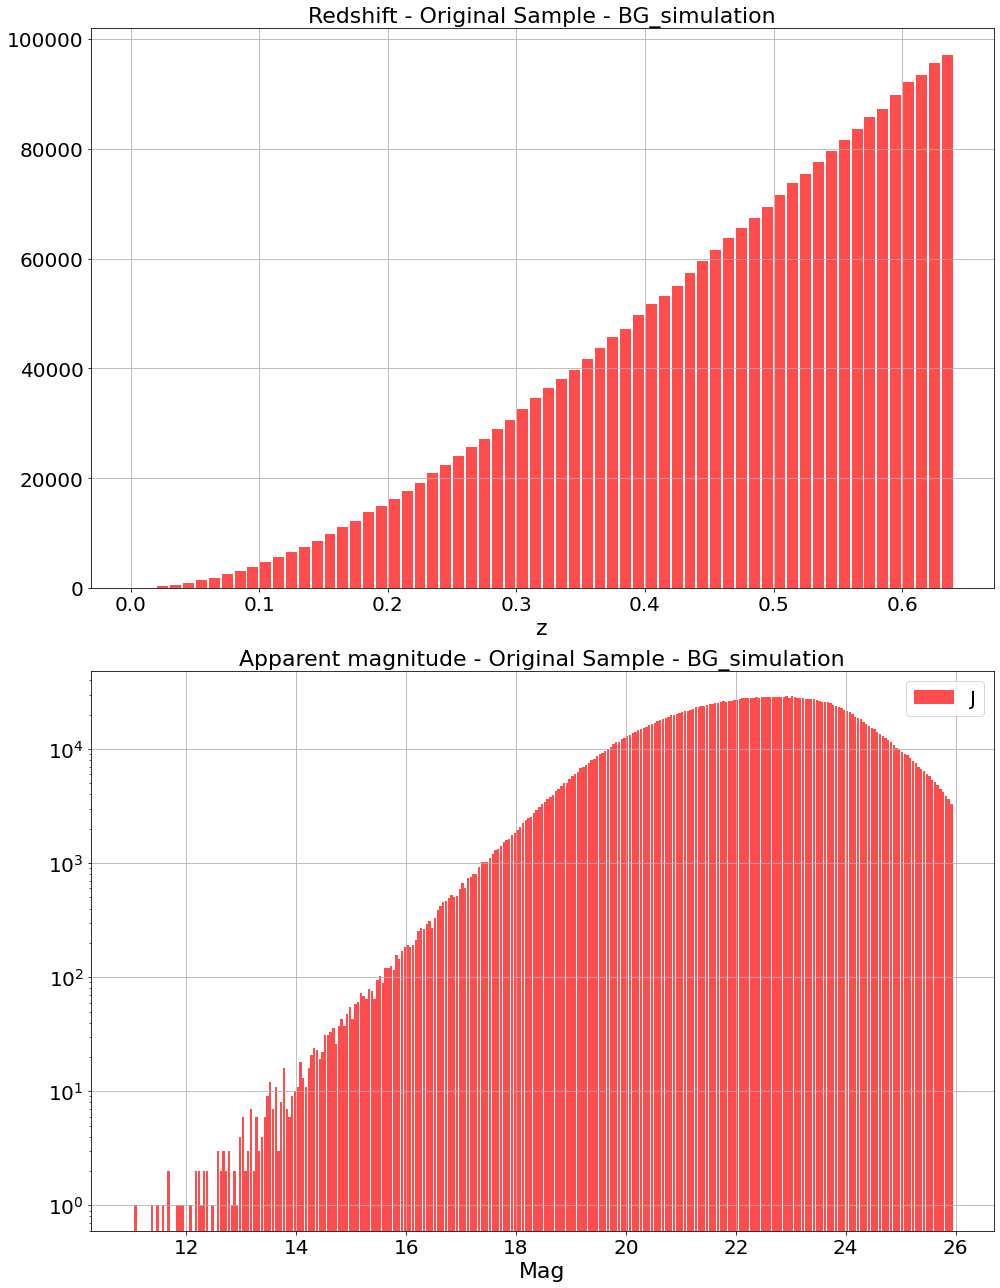

In [13]:
M_bins = np.arange(11,26,0.05)
Z_bins = np.arange(0,0.65,0.01)

fig = plt.figure(figsize=(14,18))

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

# Histograms of input sample
# Z
n1, bins1, patches = ax1.hist(x= df['REDSHIFT_ESTIMATE'], bins=Z_bins, color='r',
                            alpha=0.7, rwidth=0.85)
ax1.set_xlabel("z",size = 22)
ax1.set_title("Redshift - Original Sample - " + sample, size = 22)

#  Mag
Bins = np.linspace(16.8,17.7,20)
n2, bins2, patches = ax2.hist(x= df['vj'], bins=M_bins, color='r',
                            alpha=0.7, rwidth=0.85, label = "J")
ax2.set_title("Apparent magnitude - Original Sample - "+sample,size = 22)
ax2.set_xlabel("Mag", size = 22)
ax2.set_yscale('log')
ax2.grid()
ax1.grid()

ax2.legend(fontsize = 20)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('z_j_histograms'+sample+'.png', dpi = 250)

plt.show()

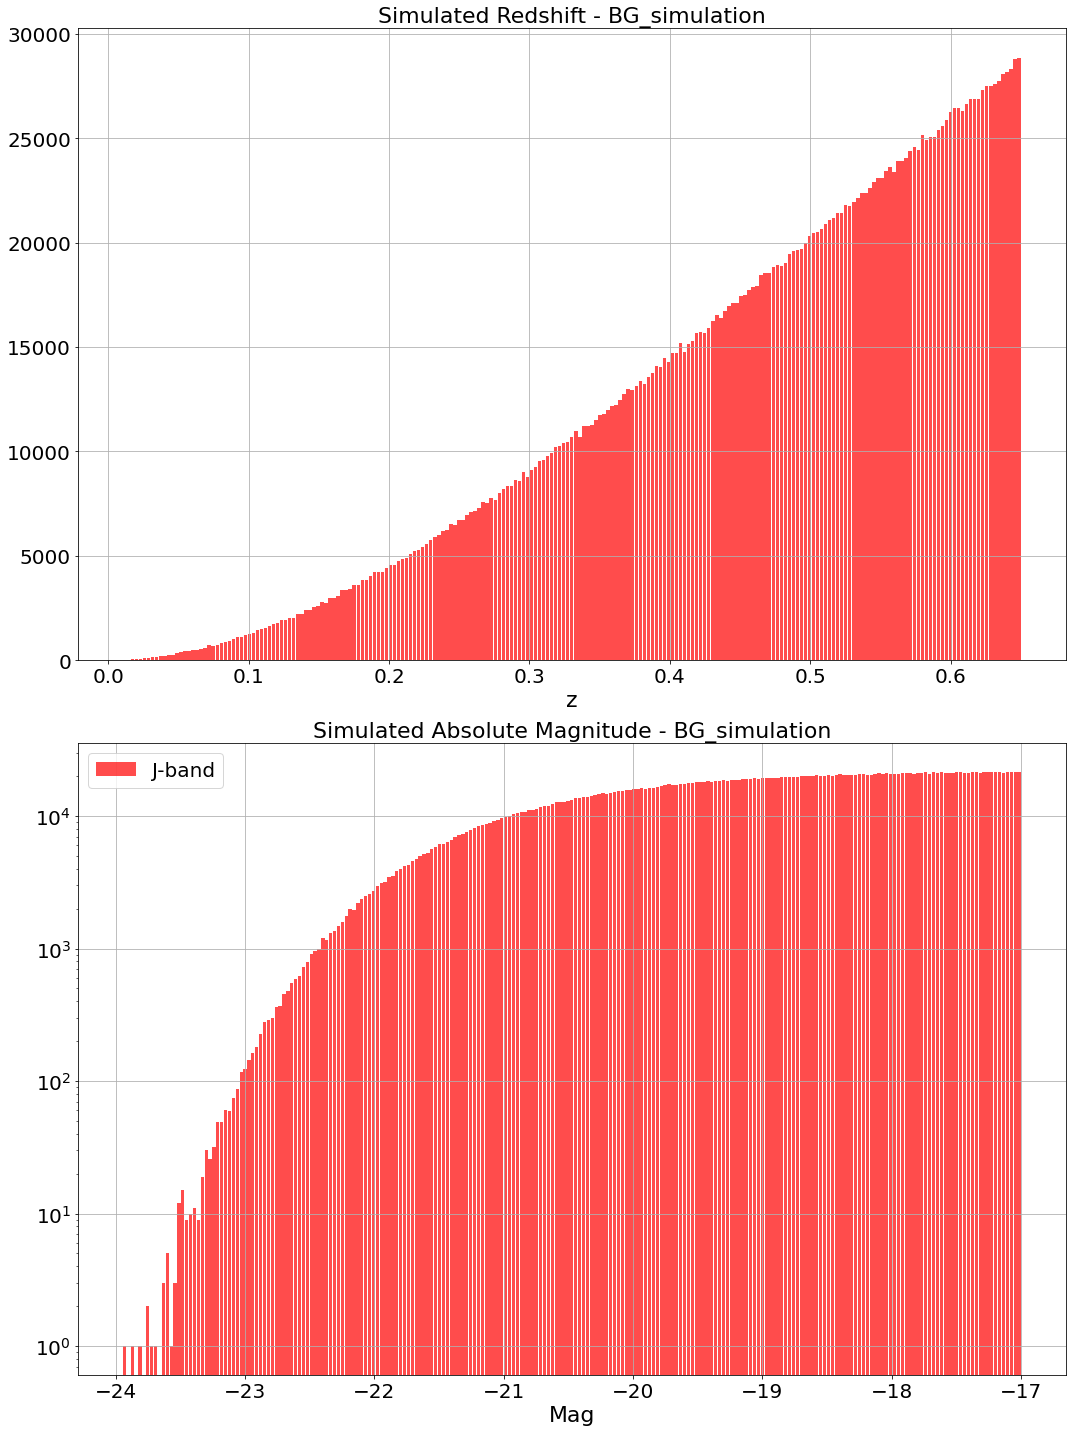

In [14]:
fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

# Histograms of input sample
# Z
n1, bins1, patches = ax1.hist(x= df['REDSHIFT_ESTIMATE'], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85)
ax1.set_xlabel("z",size = 22)
ax1.set_title("Simulated Redshift - " + sample,size = 22)

#  Mag
Bins = np.linspace(16.8,17.7,20)
n2, bins2, patches = ax2.hist(x= df['M_abs'], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85, label = "J-band")
ax2.set_title("Simulated Absolute Magnitude - "+sample,size = 22)
ax2.set_xlabel("Mag",size = 22)
ax2.set_yscale('log')
ax2.grid()
ax1.grid()

ax2.legend(fontsize = 20)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('simulated_z_mag_'+sample+'.png', dpi = 250)
plt.show()

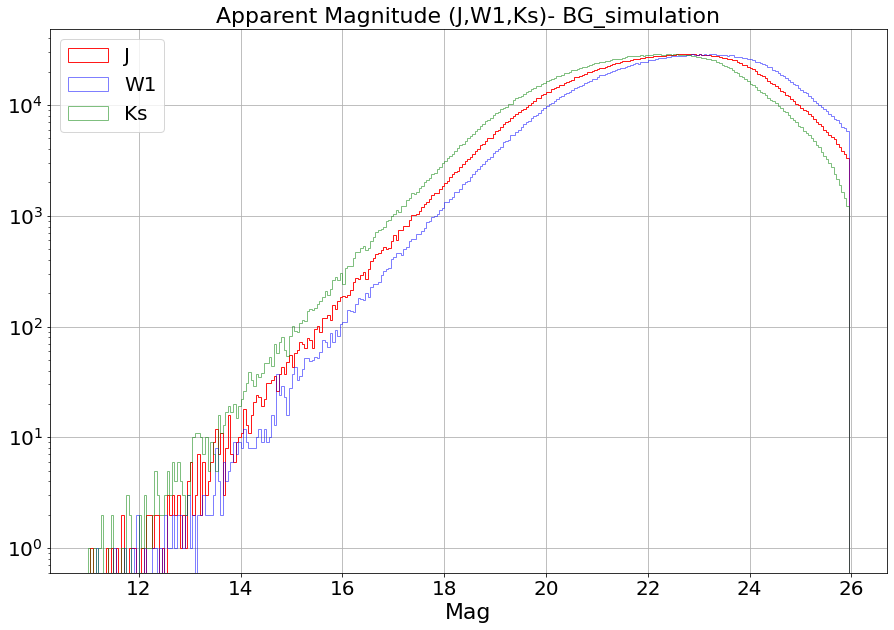

In [15]:
# All mags
M_bins = np.arange(11,26,0.05)
Z_bins = np.arange(0,0.65,0.01)

plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(x= df['vj'], bins=M_bins, 
                            color='r', alpha=0.9, rwidth=0.85,histtype=u'step', density=False, label = 'J')

n, bins, patches = plt.hist(x= df['W1'], bins=M_bins, 
                            color='b', alpha=0.5, rwidth=0.85,histtype=u'step', density=False, label = 'W1')
n, bins, patches = plt.hist(x= df['ks'], bins=M_bins, 
                            color='g', alpha=0.5, rwidth=0.85,histtype=u'step', density=False, label = 'Ks')

#plt.xlim(15,20)

plt.xlabel("Mag",size = 22)

plt.yscale("log")
plt.title("Apparent Magnitude (J,W1,Ks)- "+sample,size = 22)
plt.legend(loc=2,fontsize = 20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid()



plt.savefig("init_cut_ap_mags_" + sample +".png",dpi=200)
plt.show()

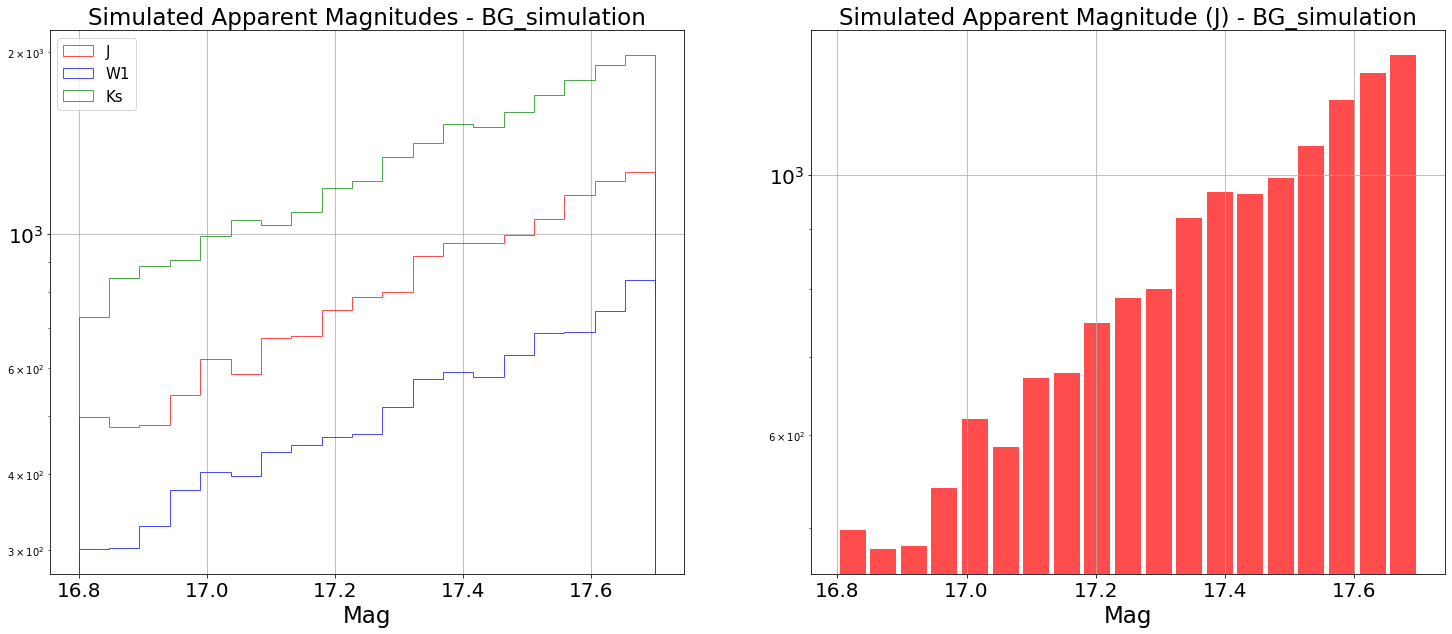

In [16]:
fig = plt.figure(figsize=(25,10))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

# Histograms of input sample
# Colours mag

n, bins, patches = ax1.hist(x= df['vj'], bins=Bins, 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'J')

n, bins, patches = ax1.hist(x= df['W1'], bins=Bins, 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'W1')
n, bins, patches = ax1.hist(x= df['ks'], bins=Bins, 
                            color='g', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Ks')
#  Mag

n2, bins2, patches = ax2.hist(x= df['vj'], bins=Bins, color='r',
                            alpha=0.7, rwidth=0.85)


ax1.set_title("Simulated Apparent Magnitudes - "+sample, size = 23)
ax1.set_xlabel("Mag", size = 23)
ax1.set_xlim

ax1.set_yscale('log')

ax2.set_title("Simulated Apparent Magnitude (J) - "+sample, size = 23)
ax2.set_xlabel("Mag", size = 23)
ax2.set_yscale('log')
ax2.grid()
ax1.grid()

ax1.legend(fontsize = 15,loc=2)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

#plt.savefig("simulated_ap_mags_and_J_" + sample +".png",dpi=200)

plt.show()

In [17]:
jmin,jmax = min(df.vj),19
sel = (df.vj>jmin) & (df.vj<jmax) & (df.REDSHIFT_ESTIMATE<0.5)
#sel = (parent) & (df.vjw1>1.6*df.vjks-1.6) & (df.vjw1<1.6*df.vjks-0.5) & (df.vjw1>-2.5*df.vjks+0.1) & (df.vjw1<-0.5*df.vjks+0.1)

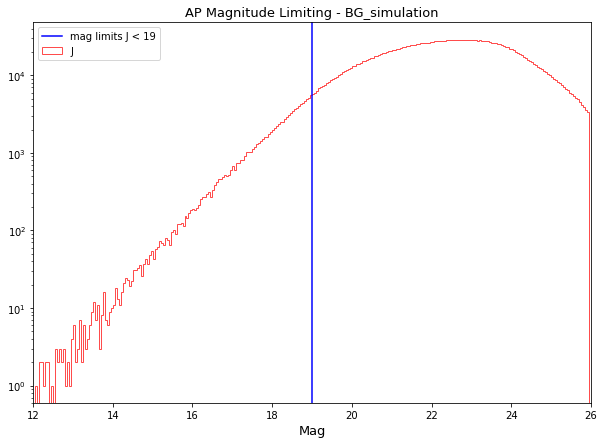

In [18]:
# All mags
M_bins = np.arange(12,26,0.05)
Z_bins = np.arange(0,0.65,0.01)
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(x= df['vj'], bins=M_bins, 
                            color='r', alpha=0.7, rwidth=0.85, histtype=u'step', density=False, label = 'J')
plt.axvline(x = jmax, c='b', label = 'mag limits J < 19')
#plt.axvline(x = jmax, c='b')

plt.xlim(12,26)
plt.xlabel("Mag",size = 13)
plt.yscale("log")
plt.title("AP Magnitude Limiting - "+sample, size = 13)
plt.legend(loc=2)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.savefig("mag_limit_" + sample +".png",dpi=200)
plt.show()

In [19]:
df2 = df[sel]

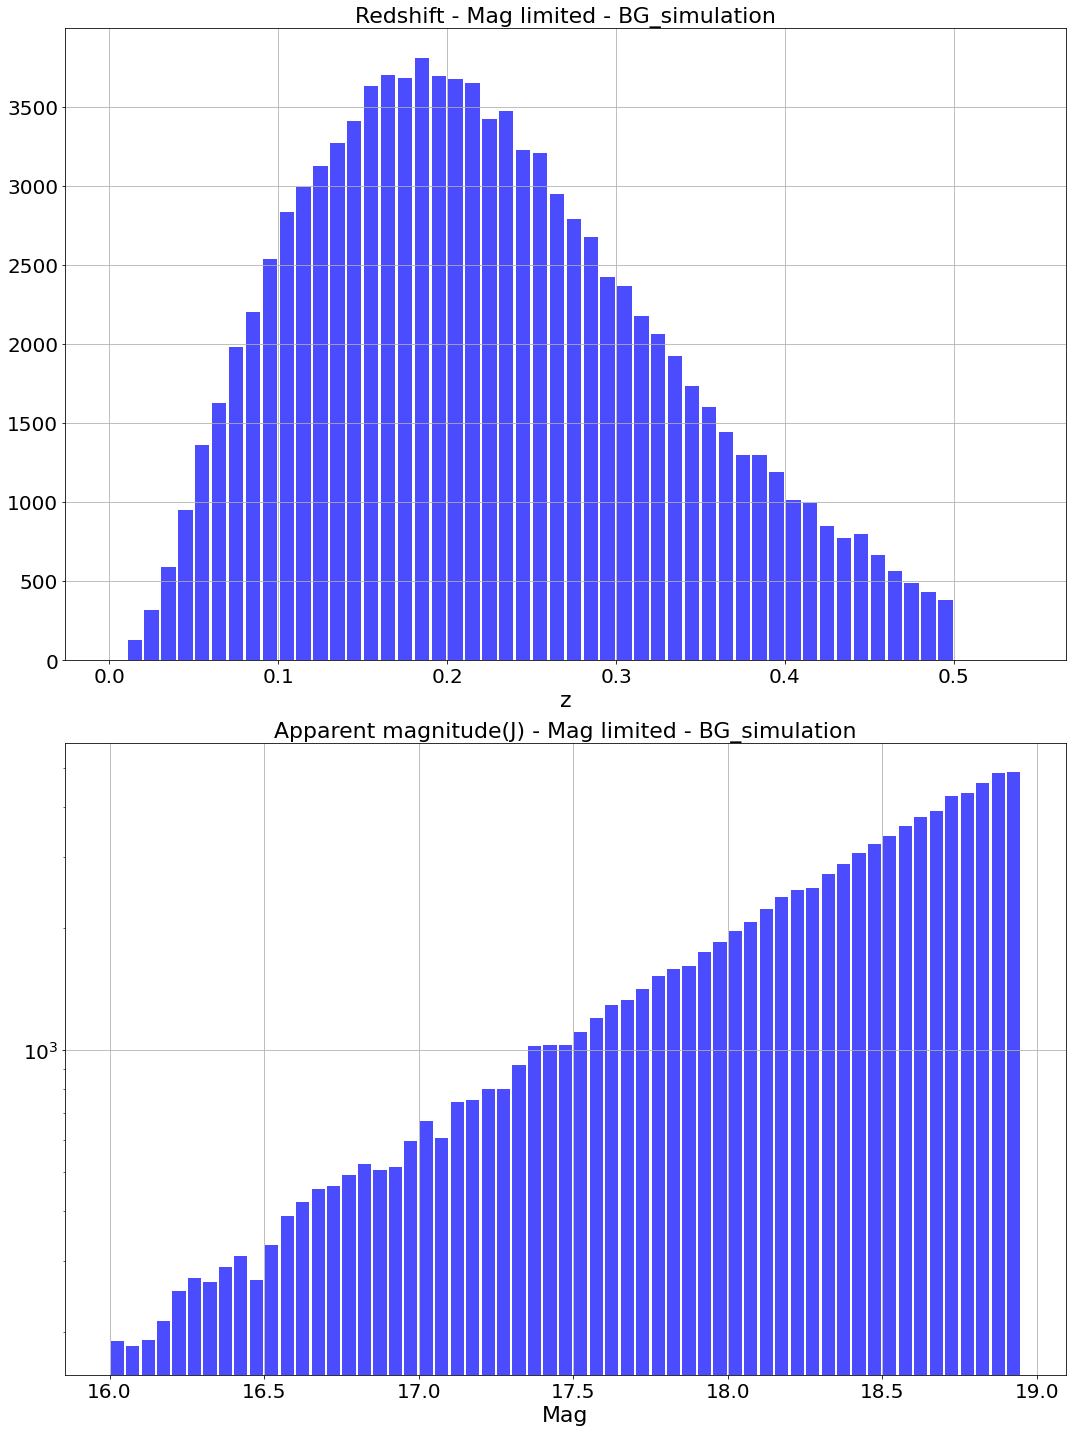

In [20]:
fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

M_bins = np.arange(16,19,0.05)
Z_bins = np.arange(0,0.55,0.01)

# Histograms of input sample
# Z
n1, bins1, patches = ax1.hist(x= df2['REDSHIFT_ESTIMATE'], bins=Z_bins, color='b',
                            alpha=0.7, rwidth=0.85)
ax1.set_xlabel("z",size = 22)
ax1.set_title("Redshift - Mag limited - " + sample,size = 22)

#  Mag
Bins = np.linspace(16.8,17.7,20)
n2, bins2, patches = ax2.hist(x= df2['vj'], bins=M_bins, color='b',
                            alpha=0.7, rwidth=0.85)
ax2.set_title("Apparent magnitude(J) - Mag limited - "+sample,size = 22)
ax2.set_xlabel("Mag", size = 22)
ax2.set_yscale('log')
ax2.grid()
ax1.grid()

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('limited_z_mag_'+sample+'.png', dpi = 250)

plt.show() 

In [21]:
med_j_ks = np.median(df2.vjks)
med_j_ks

0.4075625683792943

In [22]:
K_j = calc_kcor('J', df.REDSHIFT_ESTIMATE, 'J - K', med_j_ks)
df2 = df2.assign(K_j = K_j)

In [23]:
## Calculating Absolute Mag _ Without K
Mag = df2['vj'] - cosmo.distmod(df2.REDSHIFT_ESTIMATE)
df2 = df2.assign (abs_j = Mag)
del Mag

Mag = df2['vj'] - cosmo.distmod(df2.REDSHIFT_ESTIMATE) - (df2.K_j)
df2 = df2.assign (abs_j_k = Mag)
del Mag

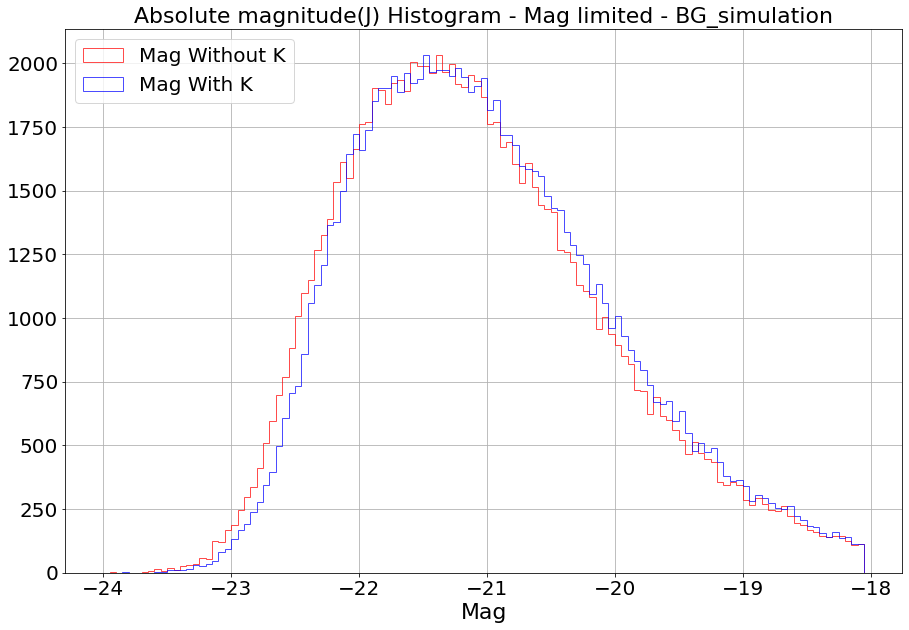

In [24]:
# All mags
M_bins = np.arange(-24,-18,0.05)
Z_bins = np.arange(0,0.5,0.01)

plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(x= df2['abs_j'], bins=M_bins, 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag Without K')

n, bins, patches = plt.hist(x= df2['abs_j_k'], bins=M_bins, 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag With K')


plt.xlabel("Mag", size = 22)
plt.title("Absolute magnitude(J) Histogram - Mag limited - "+sample,size = 22)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid()
plt.legend(loc=2,fontsize = 20)

plt.savefig("Absolute_magnitude_Mag_limited_" + sample +".png",dpi=200)
plt.show()

In [25]:
#df2 = df2[df2.abs_j_k > -24.5]

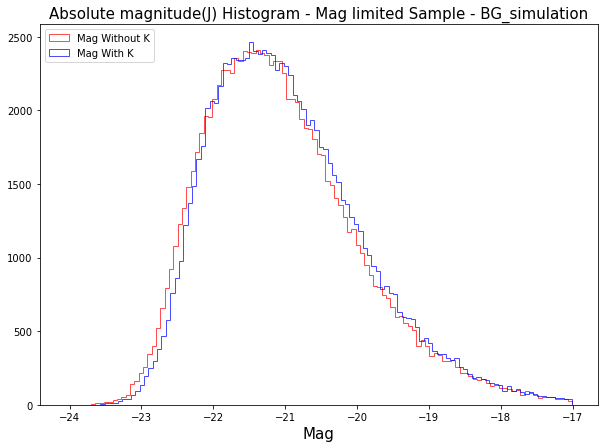

In [26]:
# All mags
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(x= df2['abs_j'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag Without K')

n, bins, patches = plt.hist(x= df2['abs_j_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag With K')


plt.xlabel("Mag",size = 15)
plt.title("Absolute magnitude(J) Histogram - Mag limited Sample - "+sample,size = 15)
plt.legend(loc=2)
#plt.savefig("Absolute magnitude(j) Histogram - Mag limited Sample - " + sample +".png",dpi=200)
plt.show()

In [27]:
dm_max = jmax - df2.abs_j
dm_min = jmin - df2.abs_j 
dm_max_k = jmax - df2.abs_j_k
dm_min_k = jmin - df2.abs_j_k
df2 = df2.assign(dm_max=dm_max,dm_min=dm_min,dm_max_k=dm_max_k,dm_min_k=dm_min_k)

In [28]:
z_arr = np.linspace(0.001,6,10000)
m_arr = [5*np.log10(cosmo.luminosity_distance(z).value) + 25 for z in z_arr]
spl_m_to_z = inter.interp1d(m_arr,z_arr)
z_max = spl_m_to_z(dm_max)
z_min = spl_m_to_z(dm_min)
df2 = df2.assign(z_max=z_max,z_min=z_min)

In [29]:
z_arr = np.linspace(0.001,5,10000)
m_arr_k = [5*np.log10(cosmo.luminosity_distance(z).value) + 25 + calc_kcor('J', z, 'J - K', med_j_ks) for z in z_arr]
spl_m_to_z_k = inter.interp1d(m_arr_k,z_arr)

In [30]:
z_max_k = spl_m_to_z_k(dm_max_k)
z_min_k = spl_m_to_z_k(dm_min_k)
df2 = df2.assign(z_max_k=z_max_k,z_min_k=z_min_k)

In [31]:
z_a = np.linspace(0,0.5,100)
k_arr = [calc_kcor('J', z, 'J - K', med_j_ks) for z in z_a]

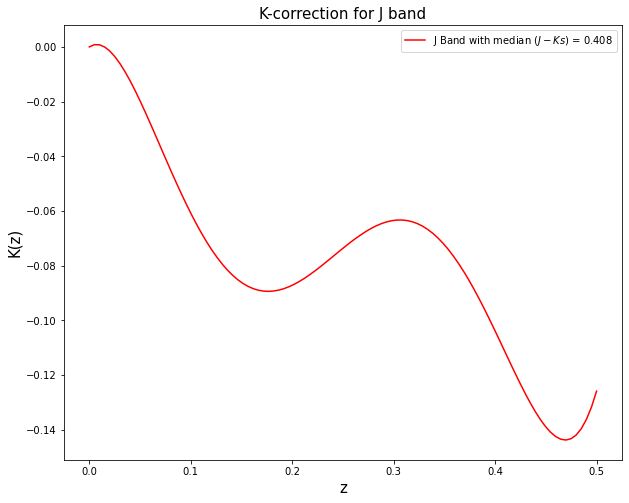

In [32]:
plt.figure(figsize=(10,8))
plt.plot(z_a,k_arr,'r', label = r'J Band with median $(J-Ks)$ = %5.3f' %med_j_ks )
plt.title("K-correction for J band",size = 15)
plt.xlabel('z',size = 15)
plt.ylabel('K(z)',size = 15)
plt.legend()

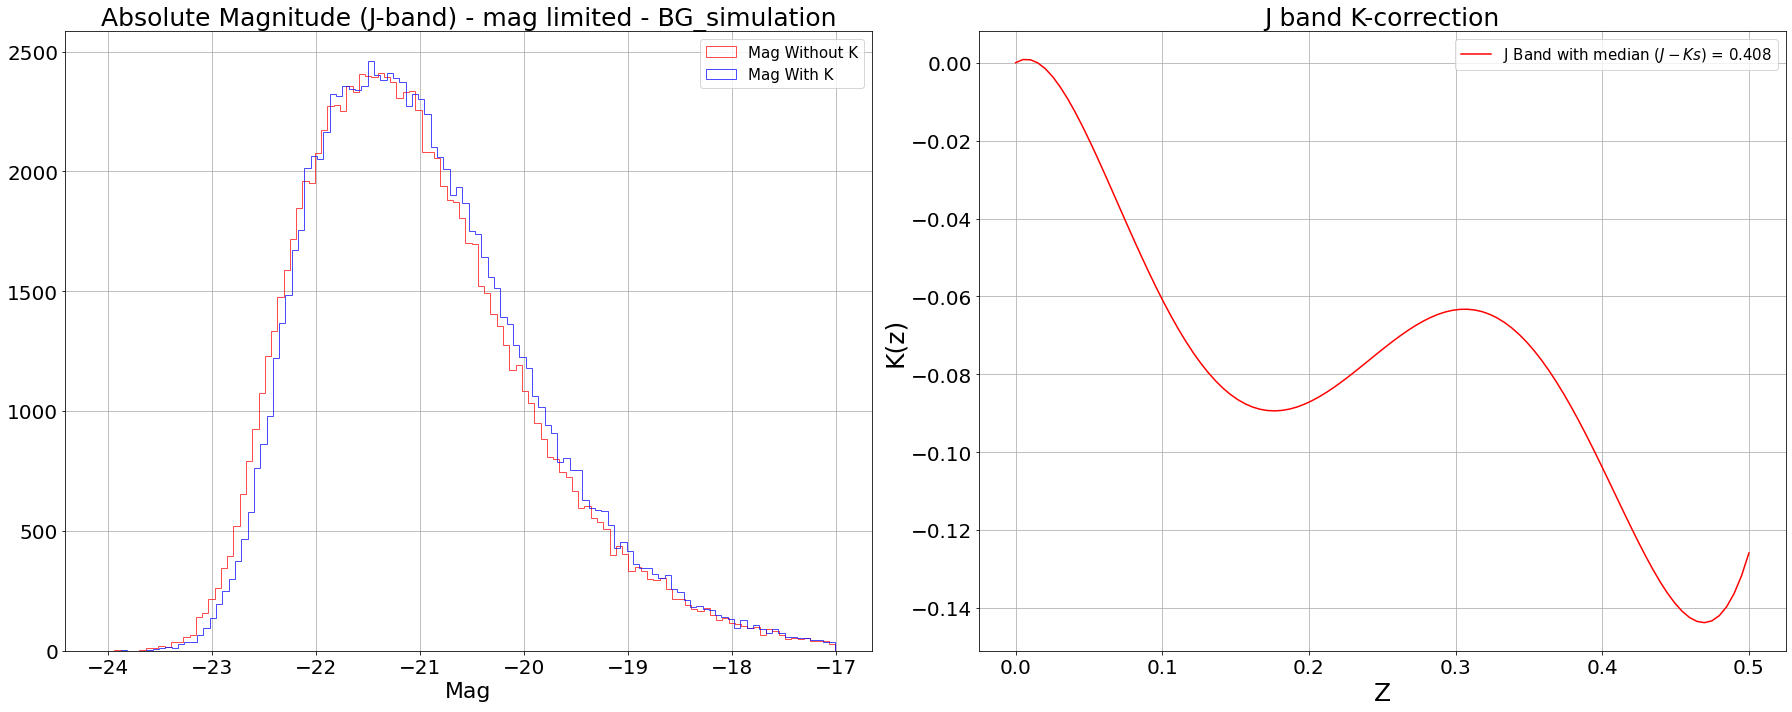

In [33]:
fig = plt.figure(figsize=(25,10))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))


# Histograms of input sample
# Mag
n, bins, patches = ax1.hist(x= df2['abs_j'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag Without K')

n, bins, patches = ax1.hist(x= df2['abs_j_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag With K')

ax1.set_xlabel("Mag",size = 22)
ax1.set_title("Absolute Magnitude (J-band) - mag limited - " + sample,size = 25)

#  K Correction
ax2.plot(z_a,k_arr,'r', label = r'J Band with median $(J-Ks)$ = %5.3f' %med_j_ks )
ax2.set_title("J band K-correction",size = 25)
ax2.set_xlabel("Z", size = 25)
ax2.set_ylabel("K(z)", size = 25)

#ax1.set_yscale('log')
ax2.grid()
ax1.grid()
ax1.legend(fontsize = 15)
ax2.legend(fontsize = 15)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('abs_mag_K_'+sample+'.png', dpi = 250)

plt.show() 

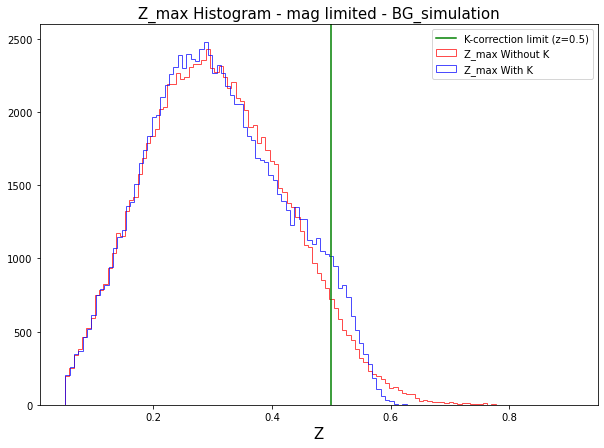

In [34]:
# All mags
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(x= df2['z_max'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max Without K')

n, bins, patches = plt.hist(x= df2['z_max_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max With K')

plt.axvline(x = 0.5, c='g', label = 'K-correction limit (z=0.5)')

plt.xlabel("Z",size = 15)
plt.title("Z_max Histogram - mag limited - "+sample,size = 15)

plt.savefig("Max_Z_Mag_limited_" + sample +".png",dpi=200)
plt.legend()
plt.show()

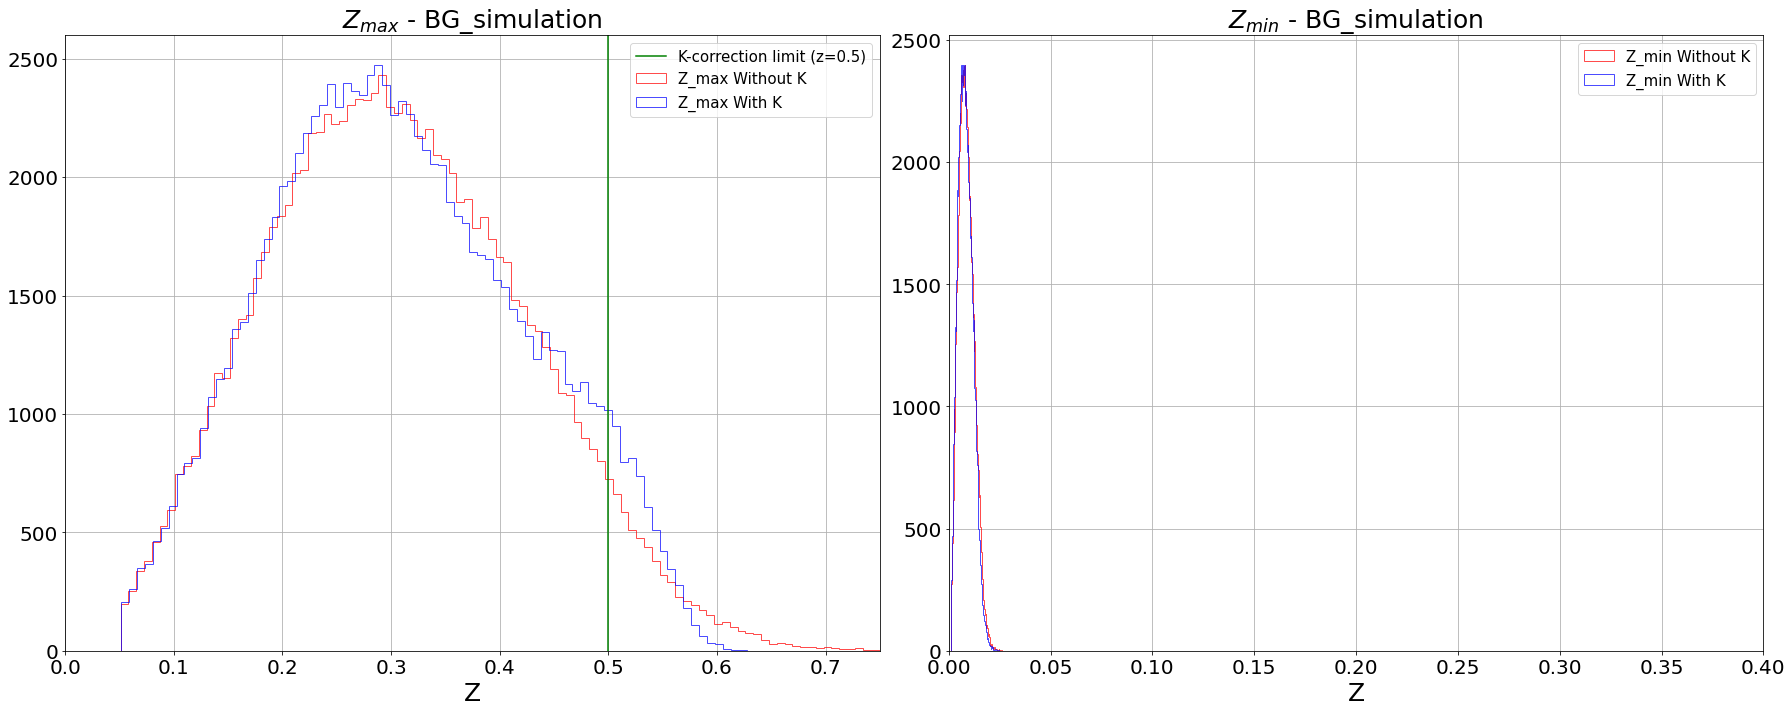

In [35]:
fig = plt.figure(figsize=(25,10))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

n, bins, patches = ax1.hist(x= df2['z_max'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max Without K')

n, bins, patches = ax1.hist(x= df2['z_max_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max With K')
ax1.axvline(x = 0.5, c='g', label = 'K-correction limit (z=0.5)')

ax1.set_title(r"$Z_{max}$ - "+sample, size = 25)
ax1.set_xlabel("Z", size = 25)

n, bins, patches = ax2.hist(x= df2['z_min'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min Without K')

n, bins, patches = ax2.hist(x= df2['z_min_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min With K')
ax2.set_title(r"$Z_{min}$ - "+sample,size = 25)
ax2.set_xlabel("Z", size = 25)

ax2.grid()
ax1.grid()

ax1.legend(fontsize = 15)
ax2.legend(fontsize = 15)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax1.set_xlim(0,0.75)
ax2.set_xlim(0,0.4)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('hist_zmin_zmax_'+sample+'.png', dpi = 250)

plt.show() 

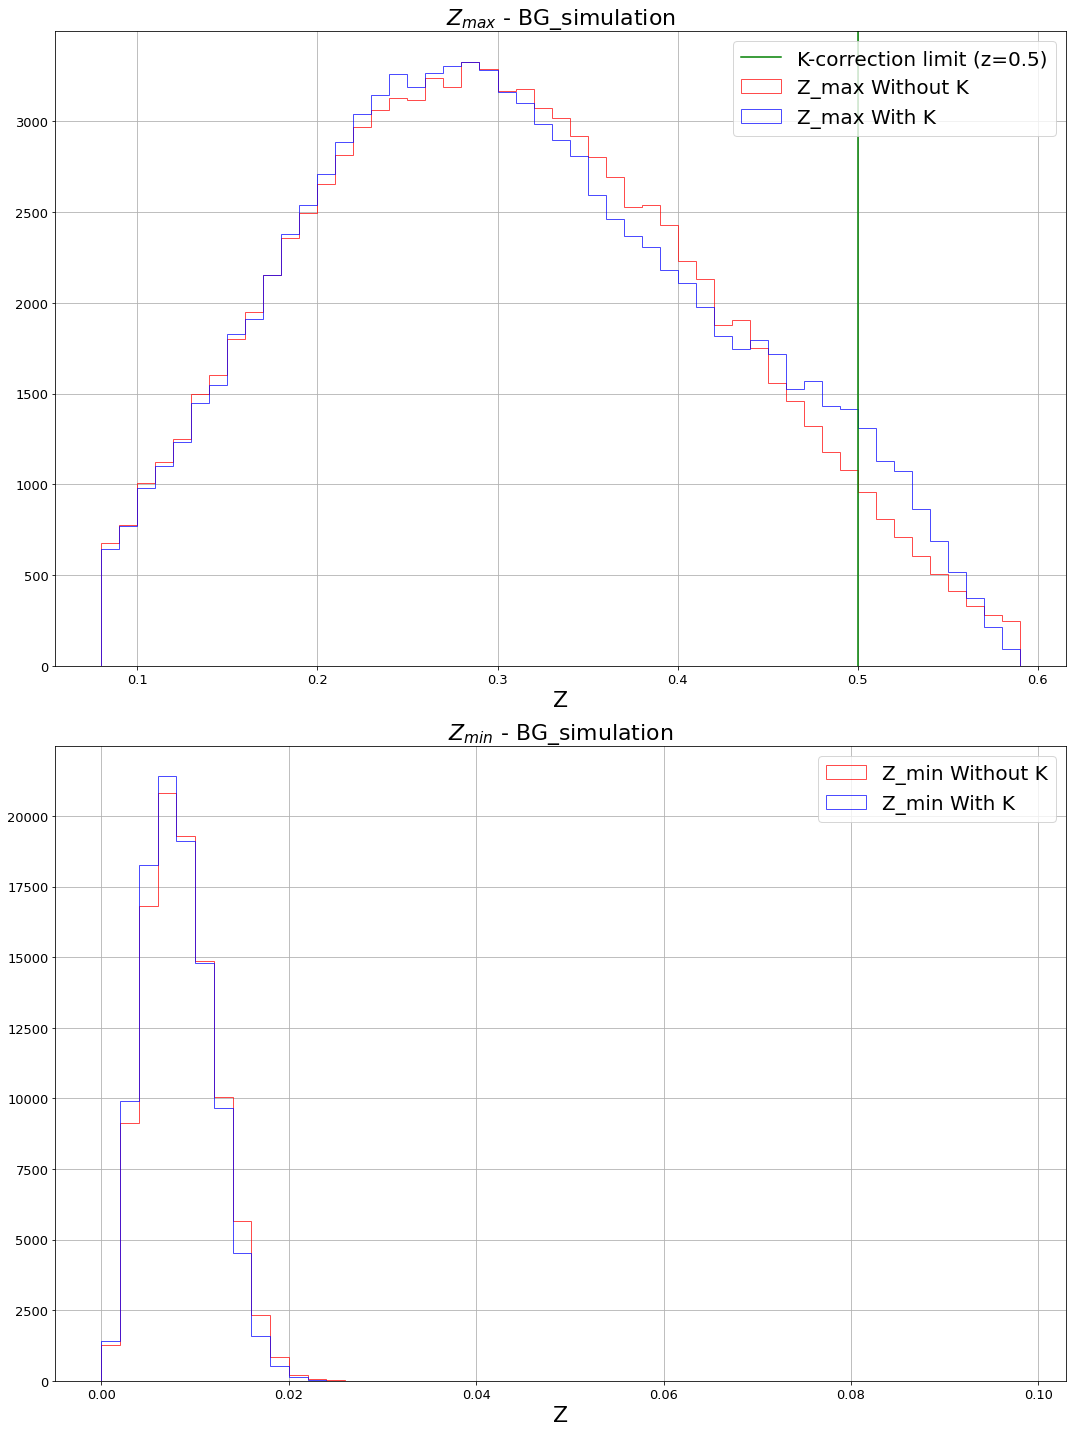

In [36]:
fig = plt.figure(figsize=(15,20))

M_bins = np.arange(-25,-17,0.05)
Z_bins = np.arange(0.08,0.6,0.01)

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

n, bins, patches = ax1.hist(x= df2['z_max'], bins=Z_bins, 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max Without K')

n, bins, patches = ax1.hist(x= df2['z_max_k'], bins=Z_bins, 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max With K')
ax1.axvline(x = 0.5, c='g', label = 'K-correction limit (z=0.5)')

ax1.set_title(r"$Z_{max}$ - "+sample, size = 22)
ax1.set_xlabel("Z", size = 22)
Z_bins = np.arange(0,0.1,0.002)

n, bins, patches = ax2.hist(x= df2['z_min'], bins=Z_bins, 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min Without K')

n, bins, patches = ax2.hist(x= df2['z_min_k'], bins=Z_bins, 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min With K')
ax2.set_title(r"$Z_{min}$ - "+sample,size = 22)
ax2.set_xlabel("Z", size = 22)

ax2.grid()
ax1.grid()

ax1.legend(loc=1,fontsize = 20)
ax2.legend(fontsize = 20)


ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()
plt.savefig('hist_zmin_zmax_'+sample+'.png', dpi = 250)


plt.show() 

In [37]:
x_y = np.linspace(0,0.8,100)

plt.figure(figsize=(15,10))
plt.scatter(df2.REDSHIFT_ESTIMATE,df2.z_max_k,s=1,label='With K Correction')
plt.scatter(df2.REDSHIFT_ESTIMATE,df2.z_max,s=0.5,label='Without K Correction')
plt.plot(x_y,x_y,label='z = z_max')
plt.xlim(0,0.8)
plt.ylim(0,0.8)
plt.title('Z_max vs Measured Z')
plt.xlabel('Measured Z')
plt.ylabel('Max Z')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(df2.REDSHIFT_ESTIMATE,df2.z_min_k,s=1,label='With K Correction')
plt.scatter(df2.REDSHIFT_ESTIMATE,df2.z_min,s=0.5,label='Without K Correction')
plt.plot(x_y,x_y,label='z = z_min')
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.title('Z_min vs Measured Z')
plt.xlabel('Measured Z')
plt.ylabel('Min Z')
plt.legend()
plt.show()

# Max Distance
df2=df2.assign(dist_max = cosmo.comoving_distance(df2.z_max))
df2=df2.assign(dist_max_k = cosmo.comoving_distance(df2.z_max_k))
# Min Distance
df2=df2.assign(dist_min = cosmo.comoving_distance(df2.z_min))
df2=df2.assign(dist_min_k = cosmo.comoving_distance(df2.z_min_k))

In [38]:
# Max Volume
df2=df2.assign(v_max = cosmo.comoving_volume(df2.z_max))
df2=df2.assign(v_max_k = cosmo.comoving_volume(df2.z_max_k))
# Min Volume
df2=df2.assign(v_min = cosmo.comoving_volume(df2.z_min))
df2=df2.assign(v_min_k = cosmo.comoving_volume(df2.z_min_k))

In [39]:
df2 = df2.assign(vc_vmin = df2.comov_volume - df2.v_min)
df2 = df2.assign(vmax_vmin = df2.v_max - df2.v_min)
df2 = df2.assign(v_ratio = df2.vc_vmin/df2.vmax_vmin)

In [40]:
df2 = df2.assign(vc_vmin_k = df2.comov_volume - df2.v_min_k)
df2 = df2.assign(vmax_vmin_k = df2.v_max_k - df2.v_min_k)
df2 = df2.assign(v_ratio_k = df2.vc_vmin_k/df2.vmax_vmin_k)

In [41]:
df3 = df2[df2.z_max_k<=0.5]

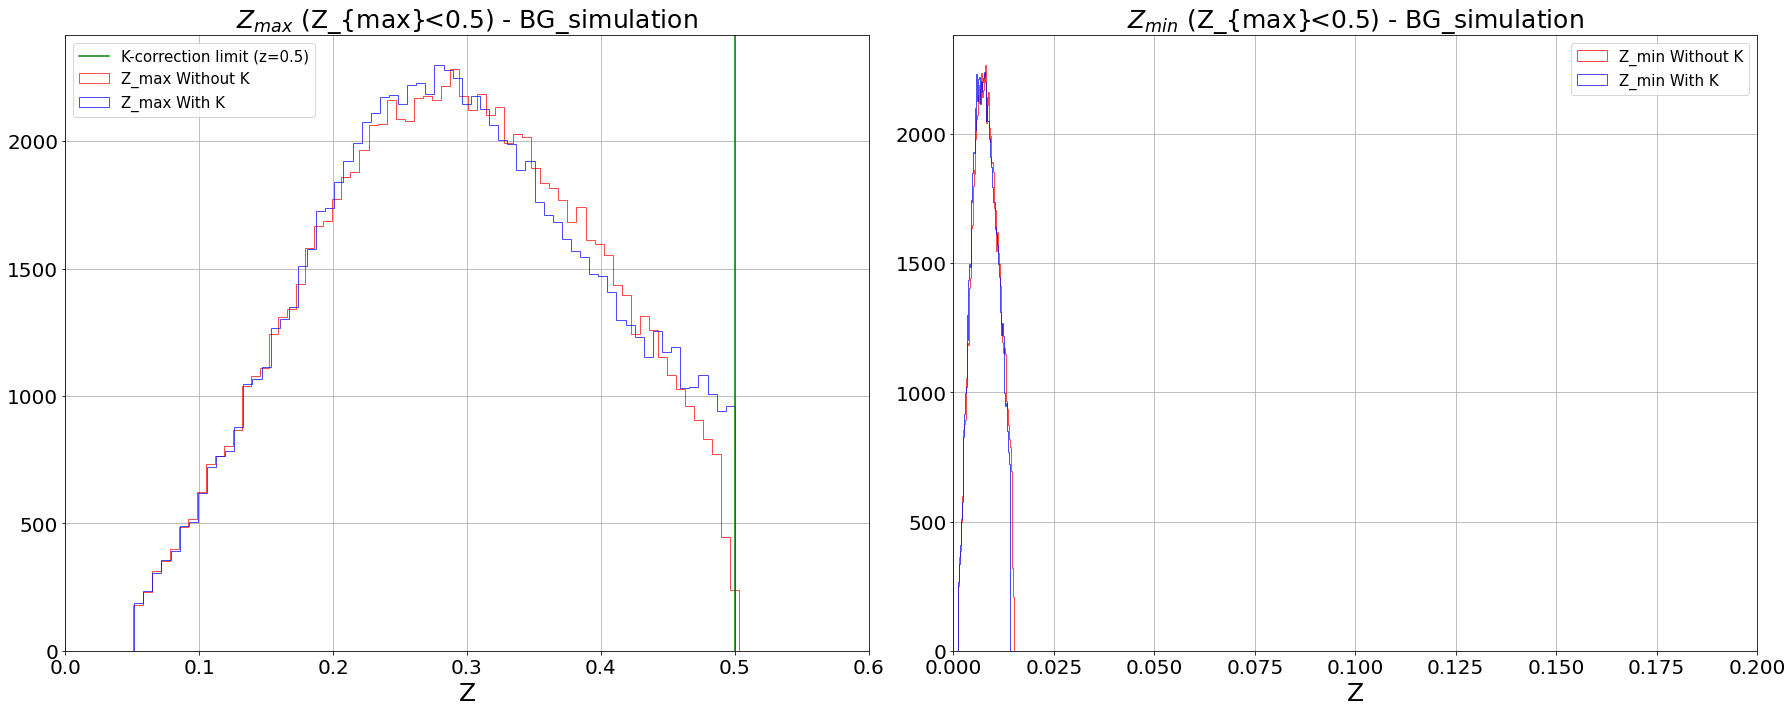

In [42]:
fig = plt.figure(figsize=(25,10))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

n, bins, patches = ax1.hist(x= df3['z_max'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max Without K')

n, bins, patches = ax1.hist(x= df3['z_max_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_max With K')
ax1.axvline(x = 0.5, c='g', label = 'K-correction limit (z=0.5)')

ax1.set_title(r"$Z_{max}$ (Z_{max}<0.5) - "+sample, size = 25)
ax1.set_xlabel("Z", size = 25)

n, bins, patches = ax2.hist(x= df3['z_min'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min Without K')

n, bins, patches = ax2.hist(x= df3['z_min_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Z_min With K')
ax2.set_title(r"$Z_{min}$ (Z_{max}<0.5) - "+sample,size = 25)
ax2.set_xlabel("Z", size = 25)

ax2.grid()
ax1.grid()

ax1.legend(fontsize = 15)
ax2.legend(fontsize = 15)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax1.set_xlim(0,0.6)
ax2.set_xlim(0,0.2)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.tight_layout()

plt.savefig('zmin_zmax_z_cuted'+sample+'.png', dpi = 250)

plt.show() 

plt.figure(figsize=(15,10))
plt.scatter(df3.REDSHIFT_ESTIMATE,df3.z_max_k,s=1,label='With K Correction')
plt.scatter(df3.REDSHIFT_ESTIMATE,df3.z_max,s=0.5,alpha=0.1,label='Without K Correction')
plt.plot(x_y,x_y,label='z = z_max')
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.title('Z_max vs Measured Z for Zmax < 0.5')
plt.xlabel('Measured Z')
plt.ylabel('Max Z')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(df3.REDSHIFT_ESTIMATE,df3.z_min_k,s=1,label='With K Correction')
plt.scatter(df3.REDSHIFT_ESTIMATE,df3.z_min,s=0.5,alpha=0.1,label='Without K Correction')
plt.plot(x_y,x_y,label='z = z_min')
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.title('Z_min vs Measured Z for Zmax < 0.5')
plt.xlabel('Measured Z')
plt.ylabel('Min Z')
plt.legend()
plt.show()

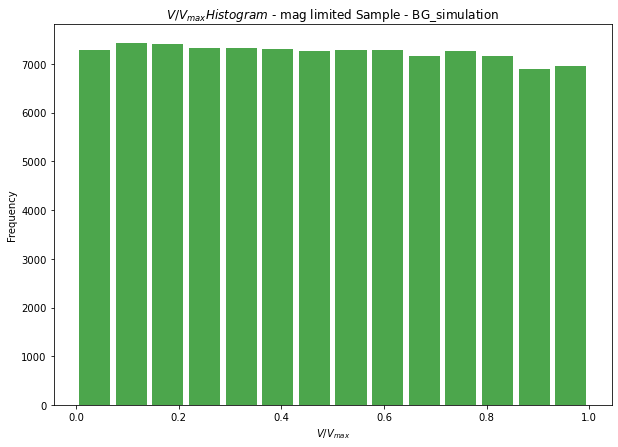

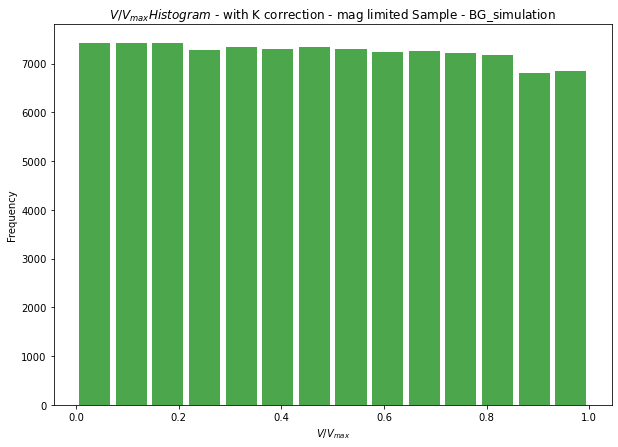

In [43]:
## V/V_max for Selected Sample

Bins = np.linspace(0,1,15)
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(df2['v_ratio'], bins=Bins, color='g',
                            alpha=0.7, rwidth=0.85, label='',density=False)
plt.xlabel(r"$V/V_{max}$")
plt.ylabel(r"Frequency")
plt.title(r"$V/V_{max} Histogram$ - mag limited Sample - " + sample)
#plt.savefig("V_V_{max} Histogram - Sellected - " + sample +".png",dpi=200)

plt.show()

## V/V_max for Selected Sample

Bins = np.linspace(0,1,15)
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(df2.v_ratio_k, bins=Bins, color='g',
                            alpha=0.7, rwidth=0.85, label='')
plt.xlabel(r"$V/V_{max}$")
plt.ylabel(r"Frequency")
plt.title(r"$V/V_{max} Histogram$ - with K correction - mag limited Sample - " + sample)
#plt.savefig("V_V_{max} Histogram - Sellected - " + sample +".png",dpi=200)

plt.show()

In [44]:
mean_v_vmax = np.mean(df3.v_ratio)
mean_v_vmax_k = np.mean(df3.v_ratio_k)

In [45]:
print (mean_v_vmax)
print (mean_v_vmax_k)

0.5008630264800298
0.497463619604039


In [46]:
1/np.sqrt(len(df3))

0.0032438991980214267

In [47]:
1/np.sqrt(12*len(df3))

0.000936433037600841

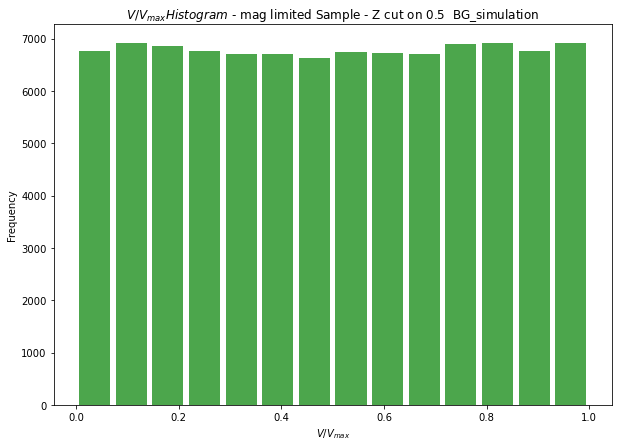

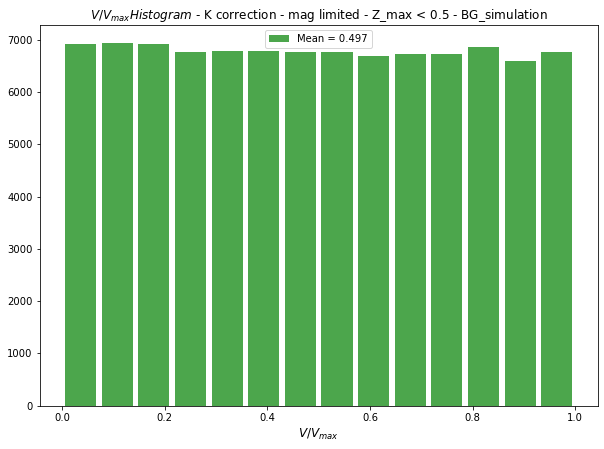

In [48]:
## V/V_max for Selected Sample

Bins = np.linspace(0,1,15)
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(df3['v_ratio'], bins=Bins, color='g',
                            alpha=0.7, rwidth=0.85, label='',density=False)
plt.xlabel(r"$V/V_{max}$")
plt.ylabel(r"Frequency")
plt.title(r"$V/V_{max} Histogram$ - mag limited Sample - Z cut on 0.5  " + sample)
#plt.savefig("V_V_{max} Histogram - Sellected - " + sample +".png",dpi=200)

plt.show()

## V/V_max for Selected Sample

Bins = np.linspace(0,1,15)
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(df3.v_ratio_k, bins=Bins, color='g',
                            alpha=0.7, rwidth=0.85, label='Mean = %5.3f' %mean_v_vmax_k)
plt.xlabel(r"$V/V_{max}$",size = 12)
#plt.ylabel(r"Frequency",size = 15)
plt.title(r"$V/V_{max} Histogram$ - K correction - mag limited - Z_max < 0.5 - " + sample,size = 12)
plt.legend()
plt.savefig("V_V_{max} Histogram - " + sample +".png",dpi=200)

plt.show()

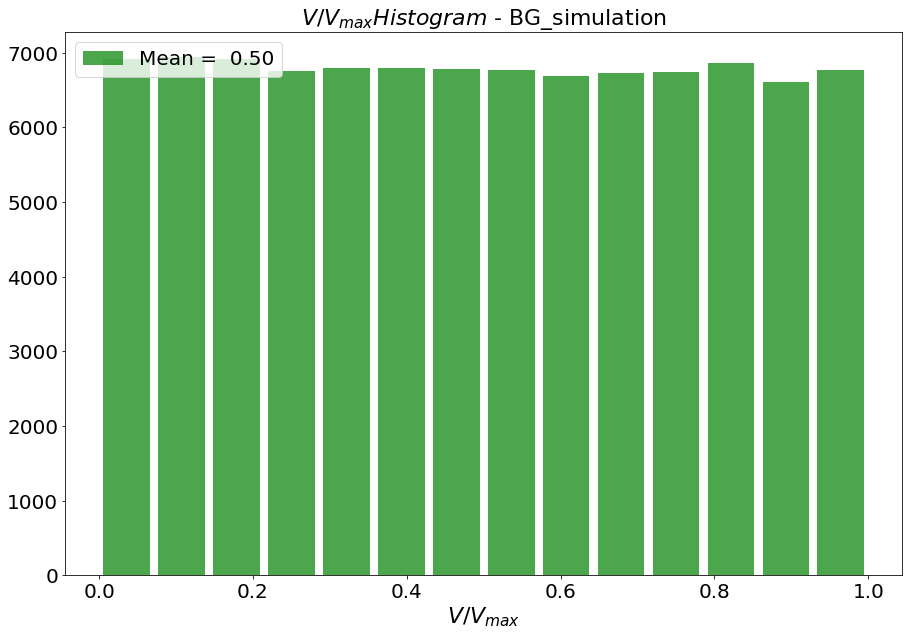

In [60]:

## V/V_max for Selected Sample
Bins = np.linspace(0,1,15)
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(df3.v_ratio_k, bins=Bins, color='g',
                            alpha=0.7, rwidth=0.85, label='Mean = %5.2f' %mean_v_vmax_k,density=False)
plt.xlabel(r"$V/V_{max}$",size = 22)
#plt.ylabel(r"Frequency")
plt.title(r"$V/V_{max} Histogram$ - " + sample,size = 22)
plt.legend(loc = 2,fontsize = 20 )
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.savefig("V_V_{max} Histogram - " + sample +".png",dpi=200)

plt.show()

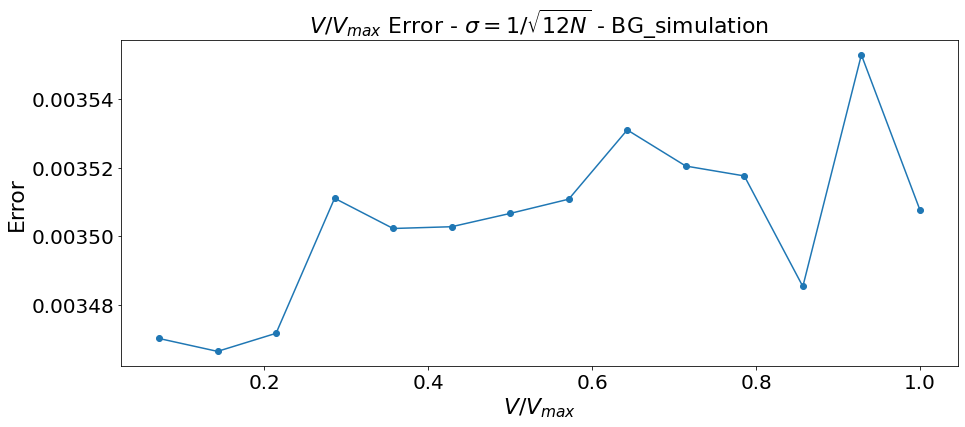

In [50]:
err = 1/np.sqrt(12*n)
## V/V_max for Selected Sample
plt.figure(figsize= (15,6))
plt.plot(Bins[1:], err, marker = "o", label = 'error')
plt.xlabel(r"$V/V_{max}$",size = 22)
plt.ylabel(r"Error", size = 22)
plt.title(r"$V/V_{max}$ Error - $\sigma = 1/\sqrt{12N}$ - " + sample,size = 22)
#plt.legend(loc = 1,fontsize = 20 )
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig("V_V_{max} erroe - 12n -" + sample +".png",dpi=200)

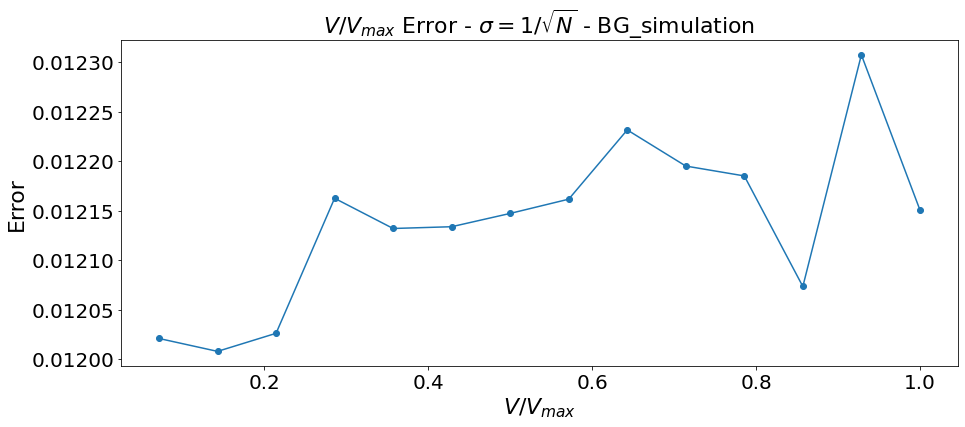

In [51]:
err = 1/np.sqrt(n)
## V/V_max for Selected Sample
plt.figure(figsize= (15,6))
plt.plot(Bins[1:], err, marker = "o", label = 'error')
plt.xlabel(r"$V/V_{max}$",size = 22)
plt.ylabel(r"Error", size = 22)
plt.title(r"$V/V_{max}$ Error - $\sigma = 1/\sqrt{N}$ - " + sample,size = 22)
#plt.legend(loc = 1,fontsize = 12 )
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig("V_V_{max} erroe - n" + sample +".png",dpi=200)

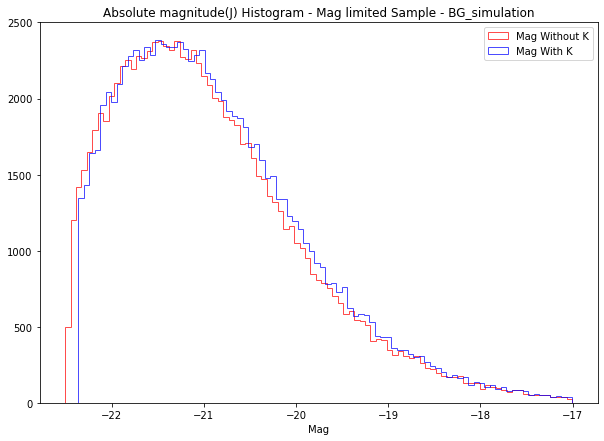

In [52]:
# All mags
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(x= df3['abs_j'], bins='auto', 
                            color='r', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag Without K')

n, bins, patches = plt.hist(x= df3['abs_j_k'], bins='auto', 
                            color='b', alpha=0.7, rwidth=0.85,histtype=u'step', density=False, label = 'Mag With K')


plt.xlabel("Mag")
plt.title("Absolute magnitude(J) Histogram - Mag limited Sample - "+sample)

#plt.savefig("Absolute magnitude(j) Histogram - Mag limited Sample - " + sample +".png",dpi=200)
plt.legend()
plt.show()

In [53]:
## Fiting Without K
## Luminosity function of Selected Sample
Bins = np.linspace(-22,-18,40)

# Number of galaxies at each Mag with weight of v/vmax
N, bin_edges = np.histogram(df3.abs_j, bins=Bins, density=False, weights = 1/df3.v_max)

# Number of galaxies at each Mag
N_tot, bin_edges_1 = np.histogram(df3.abs_j, bins=Bins, density=False)

# mean value of each bin
mean_mag = np.zeros(len(bin_edges-2))
for i in range (len(bin_edges)-1):
    mean_mag[i] = (bin_edges[i]+bin_edges[i+1])/2
mag = mean_mag[:-1]

print(N_tot)

# Error of LF
err = np.zeros(len(mag))
for i in range (len(mag)):
    err[i] = N[i] /(np.sqrt(N_tot[i])) 
    
## Fitting Curve
init_vals = [5e-4, -22, -1] # M* , Phi* , alpha
popt, pcov = curve_fit(sch_func, mag, N, sigma=err, p0=init_vals, maxfev=100000000)
phi_star = popt[0]
M_star = popt[1]
alpha = popt[2]

# Sigma
perr = np.sqrt(np.diagonal(pcov))

## Error range
popt_up = popt + (perr)
popt_dw = popt - (perr)

err_up = np.zeros(len(mag))
err_down = np.zeros(len(mag))
error= np.zeros(len(mag))


for i in range (len(mag)):
    err_up[i] = np.abs(max((N[i] - sch_func(mag[i], *popt_up)),N[i] - sch_func(mag[i], *popt_dw)))
    err_down[i] = np.abs(min((N[i] - sch_func(mag[i], *popt_up)),(N[i] - sch_func(mag[i], *popt_dw))))
    error[i] = max(err_up[i],err_down[i])
    
err
print(popt, pcov)

[3627 3898 3874 3948 4068 4100 4048 4006 3992 3812 3553 3370 3292 3087
 2909 2613 2429 2254 2015 1890 1692 1455 1359 1232 1093  988  931  781
  710  600  589  512  489  408  354  295  297  242  222]
[ 4.35168673e-06 -2.12886100e+01 -9.96580112e-01] [[8.29800444e-15 1.84755733e-09 1.01794953e-09]
 [1.84755733e-09 4.28902820e-04 2.26471548e-04]
 [1.01794953e-09 2.26471548e-04 1.40073338e-04]]


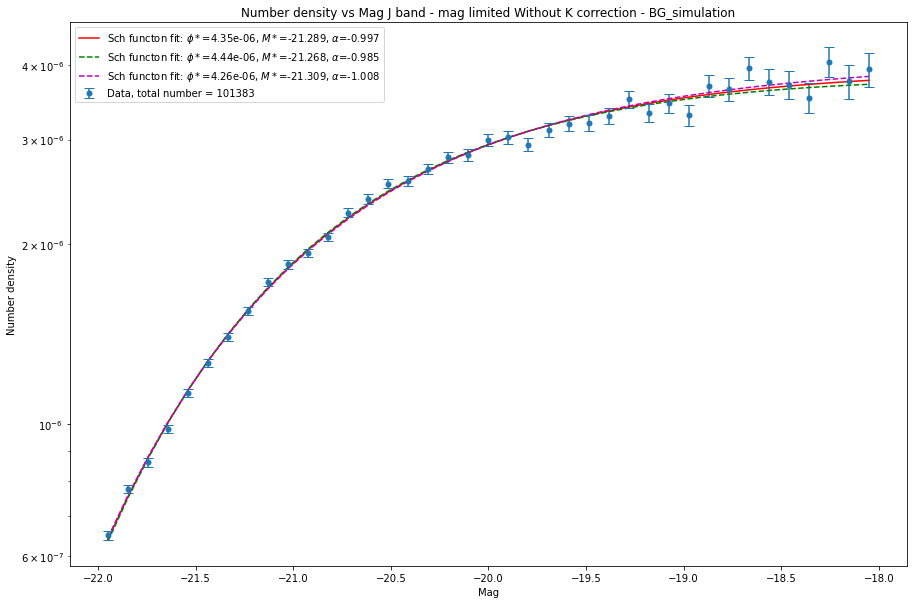

In [54]:
## Plot LF

plt.figure(figsize=(15,10))

#plt.scatter(mag,N,color = 'b',label='Data')

plt.plot(mag,sch_func(mag, *popt),color = 'r',label=r'Sch functon fit: $\phi*$=%.2e, $M*$=%5.3f, $\alpha$=%5.3f' % tuple(popt))

plt.plot(mag,sch_func(mag, *popt_up),'g--',label=r'Sch functon fit: $\phi*$=%.2e, $M*$=%5.3f, $\alpha$=%5.3f' % tuple(popt_up))

plt.plot(mag,sch_func(mag, *popt_dw),'m--',label=r'Sch functon fit: $\phi*$=%.2e, $M*$=%5.3f, $\alpha$=%5.3f' % tuple(popt_dw))

plt.errorbar(mag, N, yerr=err,fmt='o',markersize=5, capsize=5, label='Data, total number = %d' %(len(df2)))

plt.yscale('log')
plt.xlabel('Mag')
plt.ylabel('Number density')
plt.title("Number density vs Mag J band - mag limited Without K correction - " + sample)
plt.legend()
#plt.savefig("LF_all_together_J without K 2"+ sample + ".png", dpi=200)
plt.show()

In [55]:
## Fiting Without K
## Luminosity function of Selected Sample
Bins = np.arange(-22,-18,0.05)

# Number of galaxies at each Mag with weight of v/vmax
N, bin_edges = np.histogram(df3.abs_j_k, bins=Bins, density=False, weights = 1/df3.v_max_k)

N = N * (len(df)/len(df3))

# Number of galaxies at each Mag
N_tot, bin_edges_1 = np.histogram(df3.abs_j_k, bins=Bins, density=False)

# mean value of each bin
mean_mag = np.zeros(len(bin_edges-2))
for i in range (len(bin_edges)-1):
    mean_mag[i] = (bin_edges[i]+bin_edges[i+1])/2
mag = mean_mag[:-1]

print(N_tot)

# Error of LF
err = np.zeros(len(mag))
for i in range (len(mag)):
    err[i] = N[i] /(np.sqrt(N_tot[i])) 
    
## Fitting Curve
init_vals = [5e-1, -22, -1] # M* , Phi* , alpha
popt, pcov = curve_fit(sch_func, mag, N, sigma=err, p0=init_vals, maxfev=100000000)
phi_star = popt[0]
M_star = popt[1]
alpha = popt[2]

# Sigma
perr = np.sqrt(np.diagonal(pcov))

## Error range
popt_up = popt + (perr)
popt_dw = popt - (perr)

err_up = np.zeros(len(mag))
err_down = np.zeros(len(mag))
error= np.zeros(len(mag))


for i in range (len(mag)):
    err_up[i] = np.abs(max((N[i] - sch_func(mag[i], *popt_up)),N[i] - sch_func(mag[i], *popt_dw)))
    err_down[i] = np.abs(min((N[i] - sch_func(mag[i], *popt_up)),(N[i] - sch_func(mag[i], *popt_dw))))
    error[i] = max(err_up[i],err_down[i])
    
print(perr)
print(popt)

[1661 1738 1851 1904 1902 1952 1887 1963 1925 1939 2032 1965 1976 1976
 1949 1983 1947 1888 1912 1943 1816 1855 1721 1720 1678 1597 1585 1577
 1557 1478 1433 1424 1339 1286 1247 1211 1096 1136 1060  961 1010  929
  874  832  796  737  672  662  674  595  635  548  477  508  473  492
  437  379  359  366  340  281  305  294  274  253  252  263  225  209
  182  179  156  141  162  135  142  115  113]
[1.13366870e-06 1.82709882e-02 1.12976935e-02]
[ 5.96428161e-05 -2.12005007e+01 -9.89473496e-01]


In [56]:
popt_sim = [5e-4, -21.21, -1]

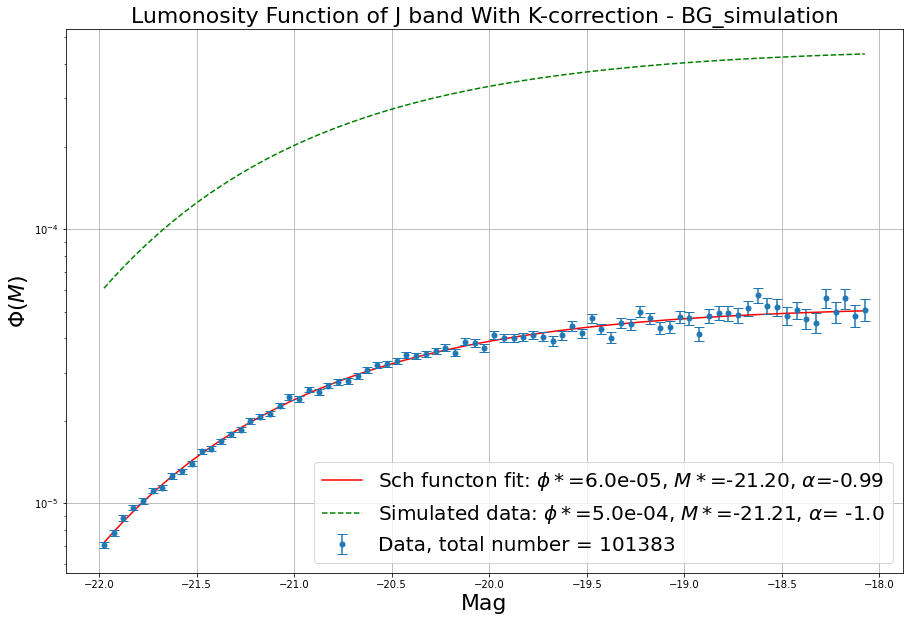

In [62]:
## Plot LF

plt.figure(figsize=(15,10))

#plt.scatter(mag,N,color = 'b',label='Data')

plt.plot(mag,sch_func(mag, *popt),color = 'r',label=r'Sch functon fit: $\phi*$=%.1e, $M*$=%5.2f, $\alpha$=%5.2f' % tuple(popt))

plt.plot(mag,sch_func(mag, 5*10**-4, -21.21, -1),'g--',label=r'Simulated data: $\phi*$=%.1e, $M*$=%5.2f, $\alpha$=%5.1f' % tuple(popt_sim))

#plt.plot(mag,sch_func(mag, *popt_dw),'m--',label=r'Sch functon fit: $\phi*$=%.2e, $M*$=%5.2f, $\alpha$=%5.1f' % tuple(popt_dw))

plt.errorbar(mag, N, yerr=err,fmt='o',markersize=5, capsize=5, label='Data, total number = %d' %(len(df2)))

plt.yscale('log')
plt.xlabel('Mag',size = 22)

#plt.xlim(-22.5,-22)

plt.ylabel(r'$\Phi(M)$', size = 22)
plt.title("Lumonosity Function of J band With K-correction - " + sample,size = 22)
plt.legend(loc = 4,fontsize = 20 )
plt.grid()
plt.savefig("LF_J_"+ sample + ".png", dpi=200)
plt.show()

In [58]:
t = Table.from_pandas(df3)
t.write('final_sim.fits', format='fits', overwrite=True)


In [59]:
print(len(df3))
print(len(df))

95031
2640213
